In [1]:
## lamsaoub_modification

In [1]:
import os.path
import sys

import os

# Récupère le chemin d'accès parent de sys.path[0]
parent_dir = os.path.dirname(sys.path[0])

sys.path.append(os.path.abspath(parent_dir))
import importlib
import algorithmes
importlib.reload(algorithmes)
from algorithmes import *
import random
import mesa
import bisect

import gym
import numpy as np
import random
import tensorflow as tf
from collections import deque
import networkx as nx
import time
  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


In [54]:
depot_c0j = CUSTOMER_DELIVERY_SERVICE_TIME + CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT/V_moy
nombre_client  = 25
STATE_SIZE = 6400
ACTION_SIZE = 3
LEARNING_RATE = 0.001
GAMMA = 0.99
BATCH_SIZE = 32
MEMORY_SIZE = 1000000

matrice_temps_Cij_shrinked = np.zeros((nombre_client+1 , nombre_client+1))

matrice_temps_Cij_shrinked[1: , 1:] = matrice_temps_Cij[:nombre_client,:nombre_client]

matrice_temps_Cij_shrinked[0,1:] = depot_c0j[:nombre_client]
matrice_temps_Cij_shrinked[1:,0] = depot_c0j[:nombre_client]

In [55]:
def get_matrice_adjacence(route):
     

    # Extraire tous les arcs de la route
    arcs_voiture = set()
    for sous_route in route:
        sous_route = [-1]+sous_route+[-1]
        arcs_voiture.update(set(zip(sous_route, sous_route[1:])))

    # Initialiser la matrice d'adjacence avec des zéros
    n = max(list(itertools.chain.from_iterable(route)))+2
    matrice_adj = [[0]*n for _ in range(n)]

    # Mettre à jour les valeurs correspondantes à chaque arc
    for i, j in arcs_voiture:
        matrice_adj[i+1][j+1] = 1
        #matrice_adj[i+1][j+1] = matrice_temps_Cij[i][j]
        
        
    
    return np.array(matrice_adj)*matrice_temps_Cij_shrinked


In [57]:
def plot_routes(Solution, pos):
    arcs_voiture = set()
    for sous_route in Solution:
        sous_route = ["dp"]+sous_route+["dp"]
        arcs_voiture.update(set(zip(sous_route, sous_route[1:])))

    # Define the edges in the graph
    edges = arcs_voiture

    # Create a directed graph from the edge list
    G = nx.DiGraph(edges)


    nx.draw(G, pos, with_labels=True)
    plt.show()

In [58]:
# genere des solution aléatoire
def get_solution_random(nombre_client):
    list_client =  [i for i in range(nombre_client)]
    random.shuffle(list_client)
    solution = get_route_version2(list_client,time_window,Q)
    return(solution)

## utiliser fonction cout pour calculer le cout d'une fonction

In [59]:
Sol_init = get_solution_random(nombre_client)


In [60]:
def get_voisinage(i,route):
    route_out = []
    if i==nombre_client-1:
        route_out =route
    else:
        G= list(itertools.chain.from_iterable(route))
        G[i],G[i+1] = G[i+1],G[i]
        route_out = get_route_version2(G,time_window,Q)

    return route_out

In [176]:
k = nombre_client-1
def get_voisinage(i,route):
    
    i = i%nombre_client
    G= list(itertools.chain.from_iterable(route))
    
    L = []

    L.extend(G[i:])
    L.extend(G[:i])

    route_out = get_route_version2(L,time_window,Q)

    return route_out

In [62]:
import gym
from gym import spaces
import numpy as np
n = nombre_client + 1

class DQNEnv(gym.Env):
    def __init__(self):
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,n*n))
        self.action_space = spaces.Discrete(nombre_client)
        self.state = np.array(get_matrice_adjacence(Sol_init)).reshape(n*n,)
        self.state_routes = Sol_init
        self.num_iterations = 10
        self.done = False
        
        self.pos = {i: (random.random(), random.random()) for i in ["dp"]+[i for i in range(n)]}
        self.pos['dp'] = (0.5,0.5)

    def reset(self):
        self.state = np.array(get_matrice_adjacence(Sol_init)).reshape(n*n,)
        self.state_routes = Sol_init
        self.done = False
        self.num_iterations = 10
        return self.state

    def step(self, action):
        
        #reward = cout(self.state_routes)
        self.state_routes = get_voisinage(action, self.state_routes)
        self.num_iterations-=1
        #reward =reward - cout(self.state_routes)
        reward = cout(Sol_init) - cout(self.state_routes)
        self.state = np.array(get_matrice_adjacence(self.state_routes)).reshape(n*n,)
        
        if self.num_iterations==0:
            self.done = True
        else:
            self.done = False
        return self.state, reward, self.done, {}
        
    def render(self):
        
        clear_output()
    
        plot_routes(self.state_routes, self.pos)
        
        time.sleep(0.1)
        
        
            

        

## deep q learning implimentation

In [77]:
import numpy as np
import random
from IPython.display import clear_output
from collections import deque

import gym

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam
import progressbar

In [64]:
import tensorflow as tf

# Define a lambda function to reshape the input tensor
reshape_func = lambda x: tf.reshape(x, shape=(1,nombre_client+1,nombre_client+1))

# Create a Lambda layer with the reshape function
reshape_layer = tf.keras.layers.Lambda(reshape_func)



In [102]:
class Agent:
    def __init__(self, enviroment, optimizer):
        
        # Initialize atributes
        #self._state_size = enviroment.observation_space.n
        self._action_size = nombre_client
        self._optimizer = optimizer
        self.enviroment = enviroment
        self.expirience_replay = deque(maxlen=2000)
        
        # Initialize discount and exploration rate
        self.gamma = 0.6
        self.epsilon = 0.1
        self.alpha = 0.1
        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.alighn_target_model()
        

    def store(self, state, action, reward, next_state, terminated):
        self.expirience_replay.append((state, action, reward, next_state, terminated))
    
    def _build_compile_model(self):

        model = Sequential()
        model.add(Flatten(input_shape=(1,(nombre_client+1)*(nombre_client+1))))
        model.add(tf.keras.layers.Dense(150, activation='tanh'))
        model.add(Dense(nombre_client, activation='tanh'))
        
        model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=self._optimizer)
        return model

    def alighn_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(nombre_client)
        
        q_values = self.q_network.predict(state)
        return np.argmax(q_values[0])

    def retrain(self, batch_size):
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        states = np.zeros((batch_size,1,n*n))
        targets = np.zeros((batch_size,nombre_client))

        k = 0
        for state, action, reward, next_state, terminated in minibatch:
            #state = state.reshape(1,n*n)
            states[k] = state.reshape(1,n*n)
            
            if terminated:

                targets[k][action] = reward
                k = k+1

            else:
                t = self.target_network.predict(next_state)
                t_s = self.target_network.predict(state)
                targets[k][action] =t_s[0][action]+ self.alpha*(reward + self.gamma * (np.amax(t)-t_s[0][action]))
                k = k+1

        self.q_network.fit(states, targets, epochs=1, verbose=0) # backprop

    """
    def retrain(self, batch_size):
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        for state, action, reward, next_state, terminated in minibatch:
            state = state.reshape(1,1,101*101)
            target = self.q_network.predict(state)
            
            if terminated:
                target[0][action] = reward
            else:
                t = self.target_network.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(t)
            
            self.q_network.fit(state, target, epochs=1, verbose=0)
            """

In [294]:
env = DQNEnv()
optimizer = Adam(learning_rate=0.01)
agent = Agent(env, optimizer)

batch_size = 32
num_of_episodes = 100
timesteps_per_episode = 1000
agent.q_network.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 676)               0         
                                                                 
 dense_18 (Dense)            (None, 150)               101550    
                                                                 
 dense_19 (Dense)            (None, 25)                3775      
                                                                 
Total params: 105,325
Trainable params: 105,325
Non-trainable params: 0
_________________________________________________________________


## Training

In [13]:
## testing & debugage not for execute
state = env.reset()
state = state.reshape(1,1,121)
agent.act(state)
next_state, reward, terminated, info = env.step(action) 

ValueError: cannot reshape array of size 676 into shape (1,1,121)

In [82]:
## testing & debugage not for execute



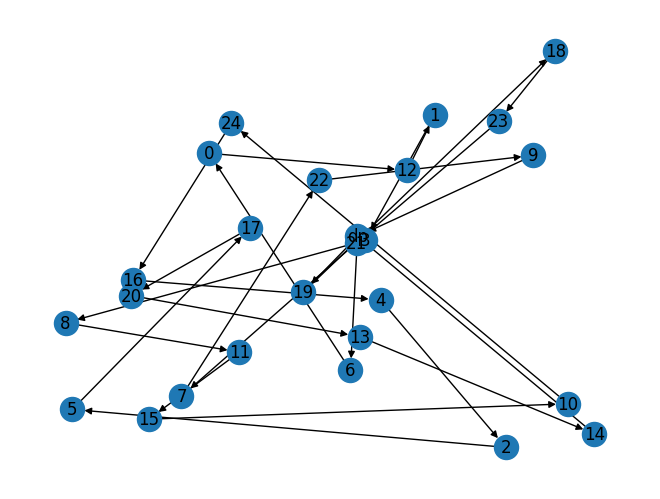

**********************************


In [381]:
num_of_episodes = 20
n = nombre_client+1
for e in range(0, num_of_episodes):
    # Reset the enviroment
    state = env.reset()
    state = state.reshape(1,1,n*n)
    
    # Initialize variables
    reward = 0
    terminated = False
    
    bar = progressbar.ProgressBar(maxval=timesteps_per_episode/10, widgets=\
[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for timestep in range(timesteps_per_episode):
        # Run Action

        #if np.random.rand() < np.exp(-e):
            #action = agent.act(state)
        
        #else : 
        action = agent.act(state)
        
        # Take action    
        next_state, reward, terminated, info = env.step(action) 
        #next_state = np.reshape(next_state, [1, 1])
        next_state = next_state.reshape(1,1,n*n)
        agent.store(state, action, reward, next_state, terminated)
        
        env.state = next_state
        state = next_state
        
        if terminated:
            agent.alighn_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            agent.retrain(batch_size)
        
        if timestep%10 == 0:
            bar.update(timestep/10 + 1)
    
    bar.finish()
    if (e + 1) % 10 == 0:
        print("**********************************")
        print("Episode: {}".format(e + 1))
        env.render()
        print("**********************************")

### Testing the model 

In [661]:
route = get_solution_random(nombre_client)
route
cout(route)

1393.4522538152444

In [388]:
route = get_solution_random(nombre_client)
print(len(route))
state = get_matrice_adjacence(route)
print(state.sum())
np.argmax(agent.q_network.predict(state.reshape(1,1,n*n)))

2
701.9779123910248


20

In [171]:
route = get_solution_random(nombre_client)

In [172]:
get_voisinage(18,route)

[20,
 5,
 0,
 3,
 12,
 1,
 17,
 9,
 16,
 22,
 15,
 14,
 7,
 10,
 13,
 21,
 2,
 23,
 4,
 18,
 19,
 6,
 11,
 8,
 24]

In [837]:
route_voisin = get_voisinage(action,route)
state = get_matrice_adjacence(route_voisin)
action = np.argmax(agent.q_network.predict(state.reshape(1,1,n*n)))
print(action)
print(route)
route = route_voisin


20
[[18, 7, 2, 19, 14, 21, 13, 15, 0, 16, 20, 24, 4, 9, 10, 3, 6, 23, 1, 17, 22, 11, 8, 5], [12]]


In [410]:
n_state, reward, done, info = env.step(action)
env.state = n_state
action = np.argmax(agent.q_network.predict(n_state.reshape(1,1,n*n)))
print(action)

1


In [356]:
cout_history = []
scores_history = []
state = env.reset()
state = state.reshape(1,1,n*n)
done = False
while not done:
        #env.render()
        #action = np.argmax(agent.q_network.predict(state))
        action = np.random.randint(nombre_client)
        n_state, reward, done, info = env.step(action)
        env.state = n_state.reshape(1,1,n*n)
        cout_history.append(cout(env.state_routes))
        

In [778]:
episodes = 50
cout_history = [1200]
for episode in range(1, episodes+1):

    state = env.reset()
    state = state.reshape(1,1,n*n)


    done = False
    score = 0 
    while not done:

        #env.render()
        action = np.argmax(agent.q_network.predict(state))
        n_state, reward, done, info = env.step(action)
        env.state = n_state.reshape(1,1,n*n)
        cout_history.append(action)
        if action in [20,24] : 
            print('enter')
            action = np.random.randint(25)
        print(action)
        
        
    print('Episode:{} Score:{}'.format(episode, score))

1
1
1
1
1
1
1
1
1
1
Episode:1 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:2 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:3 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:4 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:5 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:6 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:7 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:8 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:9 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:10 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:11 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:12 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:13 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:14 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:15 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:16 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:17 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:18 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:19 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:20 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:21 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:22 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:23 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:24 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:25 Score:0
1
1
1
1
1
1
1
1
1
1
Episode:26 Sco

## Optimization by Q learning

In [678]:
episodes = 100
cout_history_agent = [1200]
solution = []
for episode in range(1, episodes+1):
    route = get_solution_random(nombre_client)
    print(len(route))
    state = get_matrice_adjacence(route)
    #state = env.reset()
    state = state.reshape(1,1,n*n)
    
    #print(cout(env.state_routes))
    done = False
    score = 0 
    while not done:
        #env.render()

        if cout(env.state_routes) < cout_history_agent[-1] : 
            cout_history_agent.append(cout(env.state_routes))
            solution.append(env.state_routes)
        
        
        action =np.argmax(agent.q_network.predict(state))
        n_state, reward, done, info = env.step(action)
        state = n_state.reshape(1,1,n*n)
        print(action , ' : ' ,cout(env.state_routes) )
        
        
    print('Episode:{} Score:{}'.format(episode, score))

2
14  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.3653123482454
1  :  1248.6095502739377
1  :  1243.36531234824

KeyboardInterrupt: 

In [838]:
episodes = 100
cout_history_random = [1200]
solution = []
for episode in range(1, episodes+1):
    state = env.reset()
    state = state.reshape(1,1,n*n)
    
    #print(cout(env.state_routes))
    done = False
    score = 0 
    while not done:
        #env.render()

        if cout(env.state_routes) < cout_history_random[-1] : 
            cout_history_random.append(cout(env.state_routes))
            solution.append(env.state_routes)
        
        
        #action = np.argmax(agent.q_network.predict(state))
        action = np.random.randint(nombre_client)
        n_state, reward, done, info = env.step(action)
        state = n_state.reshape(1,1,n*n)
        print(action)
        
        
    print('Episode:{} Score:{}'.format(episode, score))

24
2
15
24
5
0
2
1
14
24
Episode:1 Score:0
22
5
15
16
22
6
11
17
1
1
Episode:2 Score:0
13
23
22
6
0
4
13
21
13
0
Episode:3 Score:0
18
2
13
23
6
22
3
22
1
15
Episode:4 Score:0
1
10
4
18
22
6
5
3
4
14
Episode:5 Score:0
5
20
9
22
0
23
23
23
10
18
Episode:6 Score:0
11
11
1
14
0
1
15
24
17
8
Episode:7 Score:0
9
14
9
21
20
2
2
7
12
3
Episode:8 Score:0
2
9
3
1
9
2
4
12
2
7
Episode:9 Score:0
9
6
23
12
19
11
10
23
12
0
Episode:10 Score:0
14
11
22
6
20
11
1
12
20
11
Episode:11 Score:0
20
3
9
2
2
16
15
3
9
16
Episode:12 Score:0
4
6
5
12
19
24
15
16
16
7
Episode:13 Score:0
12
12
20
17
15
3
16
5
3
11
Episode:14 Score:0
8
15
6
2
3
10
17
0
22
23
Episode:15 Score:0
17
5
0
0
10
1
9
3
6
11
Episode:16 Score:0
22
9
22
8
0
16
24
12
0
24
Episode:17 Score:0
6
1
24
22
11
9
11
1
3
13
Episode:18 Score:0
19
8
23
23
18
8
20
20
2
12
Episode:19 Score:0
19
5
20
20
7
21
6
6
17
11
Episode:20 Score:0
1
18
11
15
23
7
24
1
10
3
Episode:21 Score:0
18
22
13
5
1
20
23
3
1
19
Episode:22 Score:0
9
9
11
7
1
8
15
24
18
1
Episod

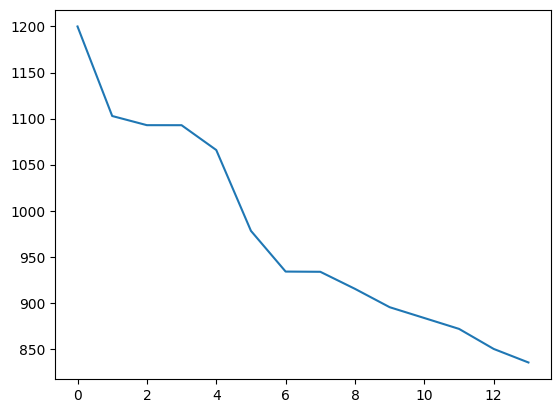

In [581]:
plt.plot(cout_history_random)
plt.plot(cout_history_agent)
